In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pysbm

import sys  
sys.path.insert(0, './')
import iaaft

# Visualize Distribution of Correlations

In [3]:
data = np.load('../data/data_centered.npy', allow_pickle=True)
print(f"first time series centered mean:{np.round(data[:,0,0].mean(), 10)}")
print(f"first time series centered std:{np.round(data[:,0,0].std(), 10)}")

first time series centered mean:0.0
first time series centered std:1.0


## Check influence of autocorrelation 

In [19]:
corr = []
autocorr = []
for k in range(1000):
    lons = np.random.randint(data.shape[1], size=2)
    lats = np.random.randint(data.shape[2], size=2)
    
    t1 = data[:, lons[0], lats[0]]
    t2 = data[:, lons[1], lats[1]]
    corr.append(np.corrcoef(t1, t2)[0,1])
    t2_surr = iaaft.surrogates(t2, 1, verbose=False)[0]
    autocorr.append(np.corrcoef(t1, t2_surr)[0,1])
corr = np.array(corr)
autocorr = np.array(autocorr)
corr_shift = np.mean(np.abs(corr - autocorr))
print(f'mean correlation caused by autocorrelation: {corr_shift}')

mean correlation caused by autocorrelation: 0.27801375512826915


In [9]:
alpha = 0.01
samples = 100000
T = 168
#T = data.shape[0]//12
t1 = np.random.normal(0,1,(samples, T))
t2 = np.random.normal(0,1,(samples, T))
test_statistics = []
for i in range(samples): 
    corr = np.corrcoef(t1[i], t2[i])[0,1]
    test_statistics.append(corr)

Quantiles/Rejection regions are [1e-05, -0.19968128038725186), (0.20008410867614748,1]


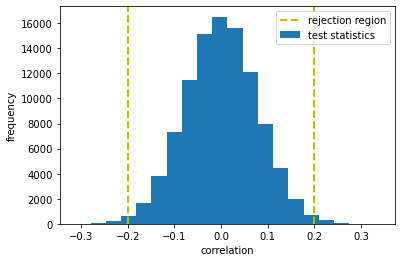

In [9]:
upper_quantile = np.quantile(test_statistics, q=1-alpha/2)
lower_quantile = np.quantile(test_statistics, q=alpha/2)
print("Quantiles/Rejection regions are [{}, {}), ({},1]".format(1/len(test_statistics), lower_quantile, upper_quantile))
plt.hist(test_statistics, label="test statistics", bins=20)
plt.axvline(upper_quantile, color='y', linestyle='dashed', linewidth=2, label="rejection region")
plt.axvline(lower_quantile, color='y', linestyle='dashed', linewidth=2)
plt.ylabel("frequency")
plt.xlabel("correlation")
plt.legend()
plt.show()

In [10]:
'''
input: time series data over WE as np array
ouput: graph that contains gridcells as nodes and an edge if correllation is sufficiently high
'''
alpha = 0.05

def build_graph(data): 
    t, lon, lat = data.shape[0], data.shape[1], data.shape[2]
    print(f"dimensions: longitude={lon}, latitude={lat}, timeseries={t}")
    graph_pos = nx.Graph()
    
    # create nodes that consist of grid cell coordinates
    for i in range(lon):
        for j in range(lat):
            graph_pos.add_node(i*lat + j)
            graph_pos.nodes[i*lat +j]['pos'] = (1.25 * j -15 ,1.25 * i + 35)
            graph_pos.nodes[i*lat +j]['ind'] = (i,j)
    graph_neg = graph_pos.copy()
    correlations = add_edges(graph_pos, graph_neg, data)
    return graph_pos, graph_neg, correlations

'''
compute correlation coefficient between the two given time series
'''
def add_edges(graph_pos, graph_neg, data): 
    t, lon, lat = data.shape[0], data.shape[1], data.shape[2]
    n = lon*lat
    correlations = np.zeros((n,n))
    nodes = graph_pos.nodes()
    for n1 in nodes:
        ind1 = nodes[n1]['ind']
        t1 = data[:, ind1[0], ind1[1]]
        for n2 in nodes:
            if n2 <= n1: 
                continue
            ind2 = nodes[n2]['ind']
            t2 = data[:, ind2[0], ind2[1]]
            # corrcoef contains correlation matrix
            corr = np.corrcoef(t1, t2)[0][1]
            correlations[n1, n2] = corr
    
    a = correlations[correlations != 0]
    upper_quantile = np.quantile(a, q=1-alpha/2)
    lower_quantile = np.quantile(a, q=alpha/2)
    print(f"upper quantile: {upper_quantile}, lower quantile: {lower_quantile}")
    adjacency_matrix_pos = correlations > upper_quantile
    adjacency_matrix_neg = correlations < lower_quantile
    for n1 in nodes:
        for n2 in nodes:
            if adjacency_matrix_pos[n1,n2]:
                graph_pos.add_edge(n1,n2)
            if adjacency_matrix_neg[n1,n2]:
                graph_neg.add_edge(n1,n2)
    return correlations

## Experiments with a downsampled data set

In [11]:
%time
small_data = np.round(data[:,::10,::10]*10**4, 1)
print("dimensions of original data set", data.shape)
print("dimensions of downsampled data set: ", small_data.shape)
#print(f"time series at (0,0):{small_data[:,0,0]}\ntime series at (9,9):{small_data[:,9,9]}\n\n")
graph_pos, graph_neg, correlations = build_graph(small_data)


n = graph_pos.number_of_nodes()
m = graph_pos.number_of_edges()
print("number of nodes", n)
print("number of edges", m)
print("ratio edges/possible edges", m/(n*(n-1)*0.5))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
dimensions of original data set (509, 161, 221)
dimensions of downsampled data set:  (509, 17, 23)
dimensions: longitude=17, latitude=23, timeseries=509
upper quantile: 0.713272875718744, lower quantile: -0.38845299967020364
number of nodes 391
number of edges 1907
ratio edges/possible edges 0.0250114761623713


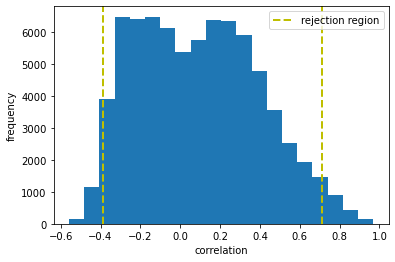

In [12]:
plt.hist(correlations[correlations!=0].flatten(), bins=20)
upper_quantile = np.quantile(correlations[correlations!=0].flatten(), q=1-alpha/2)
lower_quantile = np.quantile(correlations[correlations!=0].flatten(), q=alpha/2)
plt.axvline(upper_quantile, color='y', linestyle='dashed', linewidth=2, label="rejection region")
plt.axvline(lower_quantile, color='y', linestyle='dashed', linewidth=2)
plt.ylabel("frequency")
plt.xlabel("correlation")
plt.legend()
plt.show()

# Infer Communities via SBM

In [14]:
Ks = [4,5,6,7,8,9]
standard_partition = pysbm.NxPartition(graph=graph_pos,number_of_blocks=9)
standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=False)

In [15]:
colors = {0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'tab:cyan',5:'tab:brown', 6: 'tab:pink', 7: 'tab:gray', 8: 'tab:olive'}

### Show initial communities

/home/johannes/miniconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


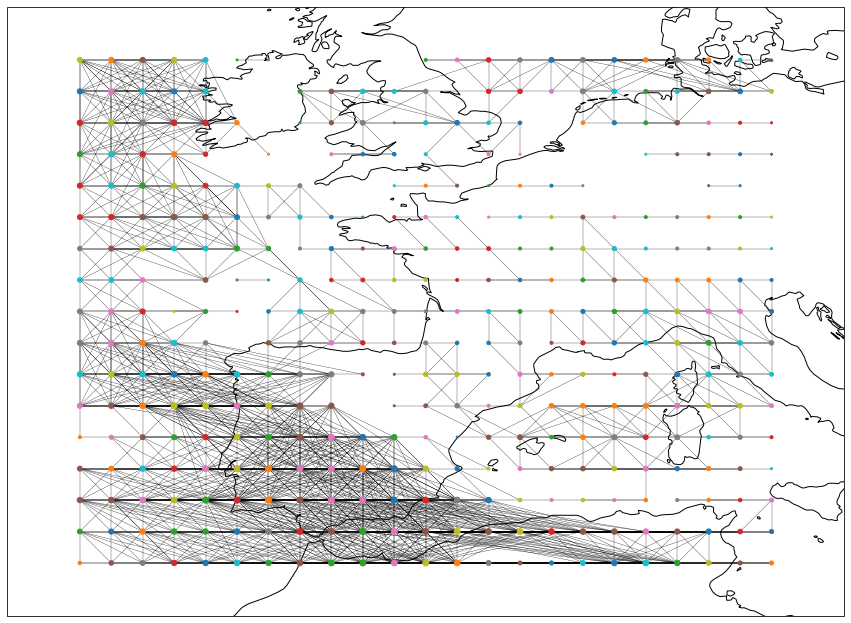

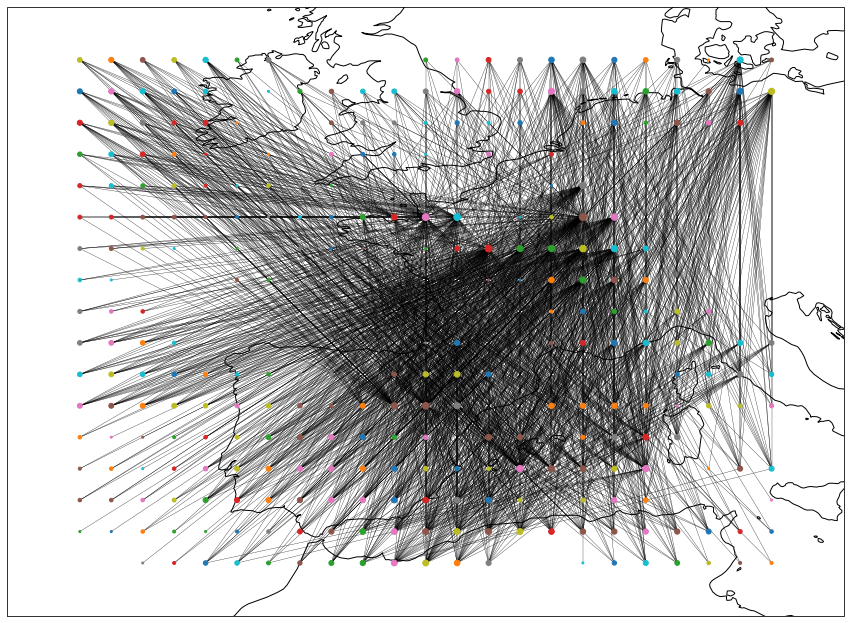

In [16]:
def plot_initial_comm(graph):

    plt.rcParams["figure.figsize"] = (15, 15)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    pos=nx.get_node_attributes(graph,'pos')
    node_size = [np.log(graph.degree[i]+0.5)*10 for i in list(graph.nodes())]

    nx.draw_networkx_nodes(graph, pos=pos,node_size=node_size, node_color=[colors[standard_partition.get_block_of_node(node)] for node in graph])
    nx.draw_networkx_edges(graph, pos=pos,width=0.3)


    plt.show()

plot_initial_comm(graph_pos)
plot_initial_comm(graph_neg)

In [17]:
def evaluate_community_sizes(graph, Ks, iterations=10, standard_partition=standard_partition):
    best_objectives = [-1000000] * len(Ks)
    best_partitions = [standard_partition] * len(Ks)
    for i, K in enumerate(Ks): 
        best_objective = best_objectives[i]
        best_partition = None
        print(f'Current K value: {K}')
        for r in range(iterations):
            standard_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
            standard_inference = pysbm.KarrerInference(graph, standard_objective_function, standard_partition)
            standard_inference.infer_stochastic_block_model()
            L=standard_objective_function.calculate(standard_partition)
            if L>best_objective:
                best_objective=L
                best_partition = standard_partition
            print(f'\tIteration {r} - Best objective value: {best_objective}, Current objective value: {L}')
        best_partitions[i] = best_partition
        best_objectives[i] = best_objective
        
    return best_partitions, best_objectives
        
print("Positive correlation: \n")
best_partitions_pos, best_objectives_pos = evaluate_community_sizes(graph_pos, Ks)

print("Negative correlation: \n")
best_partitions_neg, best_objectives_neg = evaluate_community_sizes(graph_neg, Ks)

Positive correlation: 

Current K value: 4
	Iteration 0 - Best objective value: -8181.383638964244, Current objective value: -8181.383638964244
	Iteration 1 - Best objective value: -8181.383638964244, Current objective value: -8469.825901439355
	Iteration 2 - Best objective value: -8174.11369103718, Current objective value: -8174.11369103718
	Iteration 3 - Best objective value: -7954.74487434117, Current objective value: -7954.74487434117
	Iteration 4 - Best objective value: -7954.74487434117, Current objective value: -8065.364648285236
	Iteration 5 - Best objective value: -7954.74487434117, Current objective value: -8272.139306435249
	Iteration 6 - Best objective value: -7954.74487434117, Current objective value: -7977.073679449032
	Iteration 7 - Best objective value: -7954.74487434117, Current objective value: -8369.397820110271
	Iteration 8 - Best objective value: -7954.74487434117, Current objective value: -8204.785549802333
	Iteration 9 - Best objective value: -7954.74487434117, C

## Model Selection 

In [18]:
def find_best_k(best_objectives, Ks):
    # maximum likelihood approach
    ind_ml = np.argmax(best_objectives)
    k_ml = Ks[ind_ml]
    # partition_ml = best_partitions[ind_ml]

    # bic approach 
    bic_scores = np.array(best_objectives) - np.log(n) * np.array(Ks)
    ind_bic = np.argmax(bic_scores)
    k_bic = Ks[ind_bic]
    # partition_bic = best_partitions[ind_bic]
    
    print("Maximum Likelihood Scores:", best_objectives)
    print("BIC Scores:", bic_scores)
    
    return k_ml, k_bic

k_ml_pos, k_bic_pos = find_best_k(best_objectives_pos, Ks)
k_ml_neg, k_bic_neg = find_best_k(best_objectives_neg, Ks)

Maximum Likelihood Scores: [-7954.74487434117, -7337.9217391339425, -7127.906426126288, -6691.8603803694505, -6342.899151991299, -6254.689208116097]
BIC Scores: [-7978.61970458 -7367.76527693 -7163.71867149 -6733.64133329
 -6390.64881247 -6308.40757616]
Maximum Likelihood Scores: [-5985.276353913454, -5080.198404979514, -4789.762353785089, -4564.962875885601, -4453.2958246308135, -4168.064833909675]
BIC Scores: [-6009.15118415 -5110.04194278 -4825.57459915 -4606.74382881
 -4501.04548511 -4221.78320195]


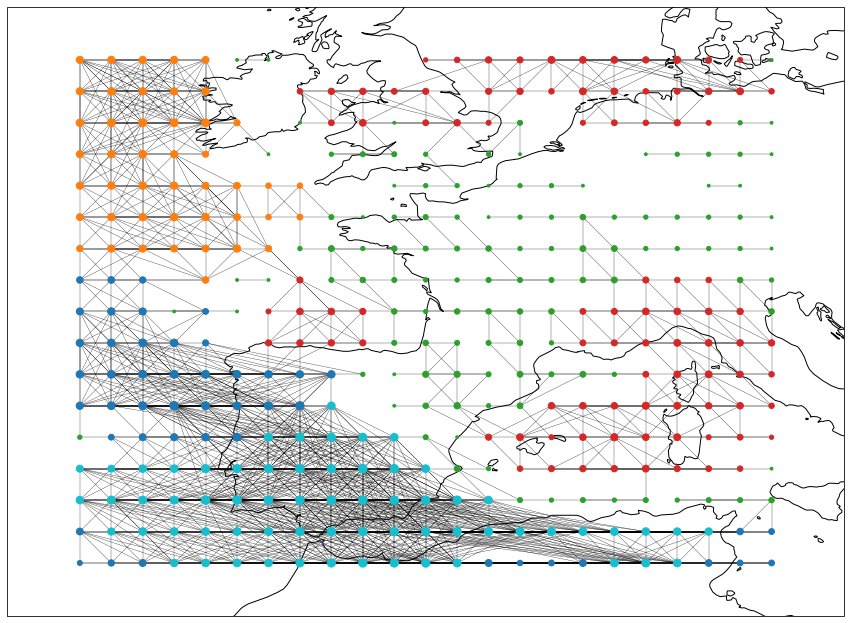

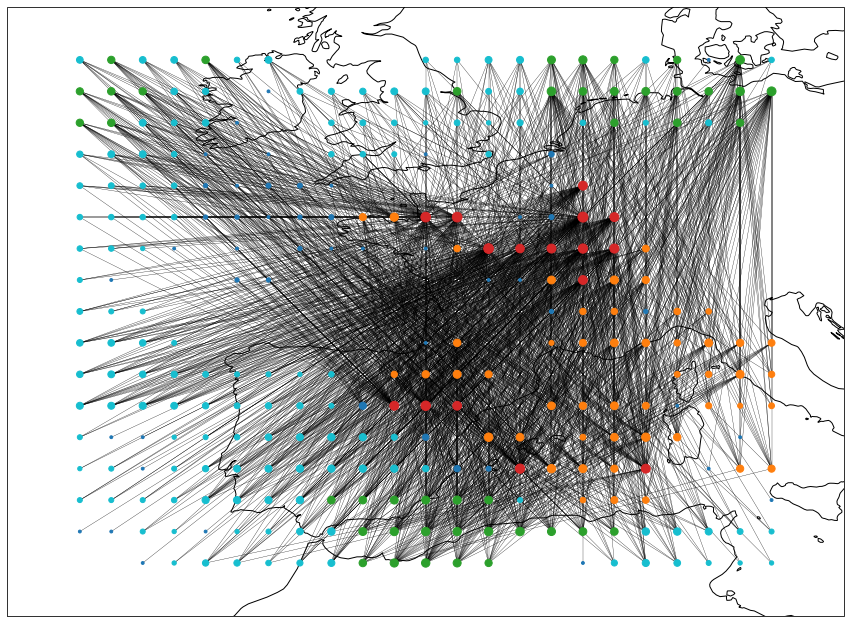

In [19]:
def plot_best_communities(graph, best_partitions, k):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    pos=nx.get_node_attributes(graph,'pos')
    node_size = [np.log(graph.degree[i]+0.5)*20 for i in list(graph.nodes())]
    nx.draw_networkx_nodes(graph, pos=pos,node_size=node_size, node_color=[colors[best_partitions[k].get_block_of_node(node)] for node in graph])
    nx.draw_networkx_edges(graph, pos=pos,width=0.3)

    plt.rcParams["figure.figsize"] = (15, 15)
    plt.show()
    
plot_best_communities(graph_pos, best_partitions_pos, 1)
plot_best_communities(graph_neg, best_partitions_neg, 1)

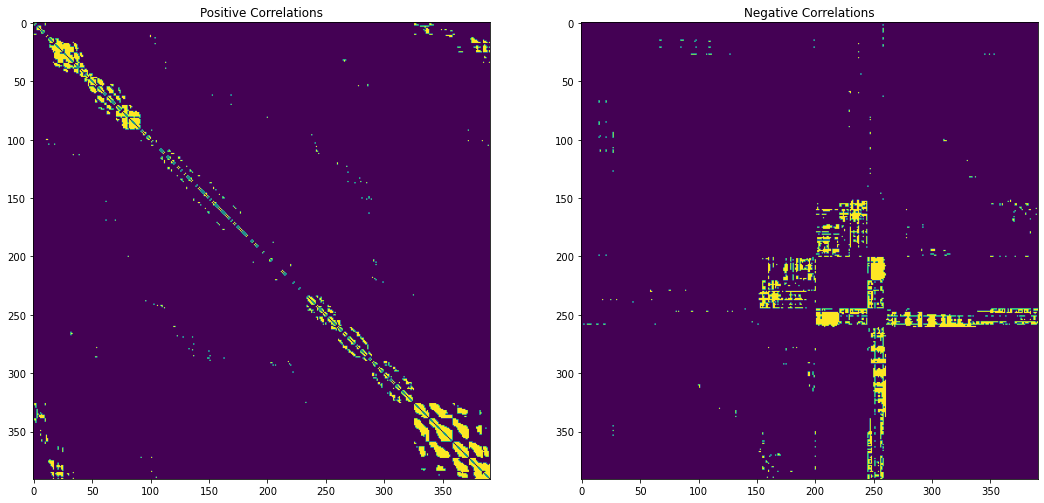

In [20]:
def find_groups(partition,graph,K=None):
    if K is None:
        K=partition.B
    groups=[[] for i in range(K)]
    for node in graph:
        q=partition.get_block_of_node(node)
        groups[q].append(node)
    return groups

def ordered_nodelist(partition,graph,K=None):
    groups = find_groups(partition,graph,K=K)
    K = len(groups)
    ordered_nodelist=sum(groups, []) # concatenate groups
    return ordered_nodelist


fig, axs = plt.subplots(1, 2, figsize=(18, 10))

axs[0].imshow(nx.to_numpy_matrix(graph_pos, nodelist=ordered_nodelist(best_partitions_pos[1], graph_pos, K=5)))
axs[0].set_title("Positive Correlations")

axs[1].imshow(nx.to_numpy_matrix(graph_neg, nodelist=ordered_nodelist(best_partitions_neg[1], graph_neg, K=5)))
axs[1].set_title("Negative Correlations")
plt.show()

In [23]:
fig, ax = plt.subplot(1)

cmap = (mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan']))

bounds = [1, 2, 4, 7, 8]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax,
    boundaries=[0] + bounds + [13],  # Adding values for extensions.
    extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal',
    label='Discrete intervals, some other units',
)

ValueError: Single argument to subplot must be a three-digit integer, not 1

<Figure size 1080x1080 with 0 Axes>